In [1]:
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard

In [2]:
tf.__version__

'2.1.0-dev20191024'

In [3]:
dataset_path = './datasets/emilwallner-datasets-colornet-2/images/Train/'
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [4]:
def image_gen(path):
    for file in os.listdir(path):
        img_path = os.path.join(dataset_path, file)
        img = np.array(load_img(img_path), dtype=float)
        yield img

# Training

In [5]:
model = Sequential([
    InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(128, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D((2, 2)),
    Conv2D(2, 3, padding='same', activation='tanh'), 
])
model.compile(optimizer='adam', loss='mse')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [7]:
batch_size = 1
dataset_size = 10

X = []
gen = image_gen(dataset_path)
for _ in range(dataset_size):
    img = next(gen)
    X.append(img)
X = np.array(X, dtype=float)
print(X.shape)

split = int(0.9*len(X))
X_train = X[:split]
X_train = 1.0/255*X_train

(10, 256, 256, 3)


In [8]:
datagen = ImageDataGenerator()
def image_a_b_gen(batch_size):
    for batch in datagen.flow(X_train, batch_size=batch_size):
        lab_batch = color.rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), y_batch)

In [9]:
TensorBoard(log_dir='/output')
model.fit_generator(image_a_b_gen(batch_size), steps_per_epoch=1, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 264ms/step - loss: 0.7419
Epoch 2/1000
1/1 [==============================] - 0s 226ms/step - loss: 0.9709
Epoch 3/1000
1/1 [==============================] - 0s 218ms/step - loss: 0.9297
Epoch 4/1000
1/1 [==============================] - 0s 220ms/step - loss: 0.8039
Epoch 5/1000
1/1 [==============================] - 0s 216ms/step - loss: 0.6965
Epoch 6/1000
1/1 [==============================] - 0s 212ms/step - loss: 0.7108
Epoch 7/1000
1/1 [==============================] - 0s 213ms/step - loss: 0.4638
Epoch 8/1000
1/1 [==============================] - 0s 217ms/step - loss: 0.7629
Epoch 9/1000
1/1 [==============================] - 0s 216ms/step - loss: 0.3809
Epoch 10/1000
1/1 [==============================] - 0s 215ms/step - loss: 0.2981
Epoch 11/1000
1/1 [==============================] - 0s 210ms/step - loss: 0.0603
Epoch 12/1000
1/1 [==============================] - 0s 217ms/step - loss: 0.0876
Epoch 13/1000
1/1 [======

In [10]:
img = color.rgb2lab(1.0/255*X[split:])
X_test = img[:,:,:,0]
X_test = X_test.reshape(X_test.shape+(1,))
y_test = img[:,:,:,1:]
y_test = y_test / 128
print(X_test.shape, y_test.shape)
print(model.evaluate(X_test, y_test, batch_size=batch_size))

(1, 256, 256, 1) (1, 256, 256, 2)
1/1 [==============================] - 0s 100ms/sample - loss: 0.0033
0.003328465623781085


In [11]:
print(X_test.min(), X_test.max())
print(y_test.min(), y_test.max())

4.113329168737636 99.07093945309146
-0.1434832820977356 0.2512371383510112


In [12]:
def concat_L_ab(L, ab):
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    img[:,:,0] = L[:,:,0]
    img[:,:,1:] = ab * 128
    return color.lab2rgb(img)

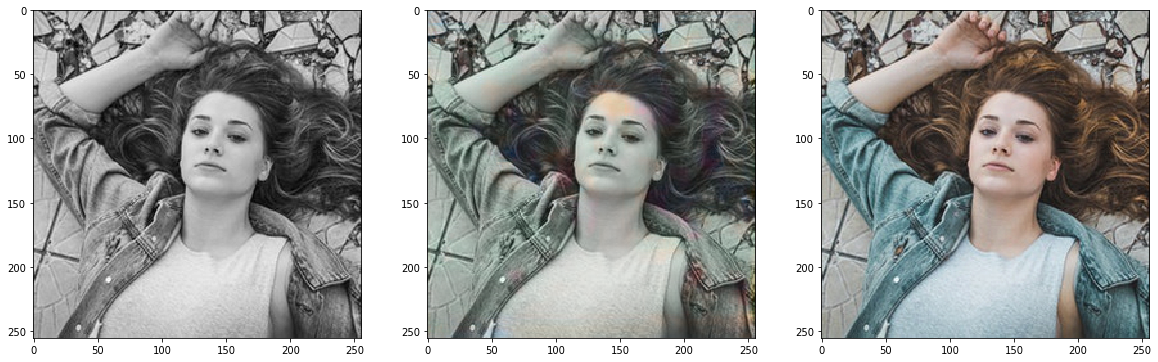

In [14]:
index = 0
img = X_test[index,:,:,:1]
label = y_test[index]

output = model.predict(np.array([img], dtype=float))

plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(img[:,:,0], cmap=plt.cm.gray)

plt.subplot(1,3,2)
plt.imshow(concat_L_ab(img, output), cmap=plt.cm.binary)

plt.subplot(1,3,3)
plt.imshow(concat_L_ab(img, label), cmap=plt.cm.binary)

plt.show()